### The following infection data are all artificially synthesized and are only for algorithm demonstration.

In [1]:
import numpy as np 
import pandas as pd
import os
import csv
import random 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import scipy.stats as st
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

#### Intialization

In [ ]:
# Please replace it with your local storage location.
data_path='/path/for/data/'
M_t=41*7+5#Statistical duration of mobility data.
cluster_num=5
#Mobility data
M_norm = np.loadtxt(data_path+'M_normal.txt', delimiter = ',').reshape((M_t,42,42*cluster_num))#The first parameter is the number of weeks. 
density=np.loadtxt(data_path+'density.txt', delimiter = ',').reshape((42,42*cluster_num))#The second dimension is the number of UHFs multiplied by the number of place categories.
dwell=np.loadtxt(data_path+'dwell.txt', delimiter = ',').reshape((42,42*cluster_num))
#Read in the simulated infection data at the city level and the UHF level.
N_raw=pd.read_excel(data_path+'NYCpop.xlsx',usecols=['num'],dtype='int')
N_all=N_raw.values
NYC_real_case=np.loadtxt(data_path+'/NYC_sim_obs_102.txt', delimiter = ',')
uhf_real_case=np.loadtxt(data_path+'/uhf_sim_obs_14_42.txt', delimiter = ',').reshape((14,42))
uhf_name=pd.read_excel(data_path+'uhfOrder.xlsx',usecols=['UHF_name'],dtype='str')

#Set transmission parameters.
Z=3.59
D=3.56
L=180
s_factor=np.array([0.0077804 , 0.02339975, 0.03096405,0.03509373, 0.020644  ,
       0.0248404 , 0.01729817, 0.02062146, 0.02336571, 0.03521075,
       0.01557102, 0.00760455, 0.06664087, 0.03892939, 0.0254785 ,
       0.01601171, 0.03034952, 0.02062874, 0.02491628, 0.02035715,
       0.01355837, 0.02436521, 0.02877314, 0.02579249, 0.01574011,
       0.01093734, 0.02100978, 0.00591962, 0.02110973, 0.08461017,
       0.01597016, 0.00724917, 0.03076374, 0.01372457, 0.03013459,
       0.03678055, 0.02433973, 0.02106431, 0.00654353, 0.01393221,
       0.01296151, 0.02901384])#Allocate it to UHF in a certain proportion

#Read in the simulated observation rate
sim_raw=pd.read_csv(data_path+"obs_rate_poly_uhf.csv",dtype='float')
sim_daily_rate=sim_raw.values

#Date-to-week index
f = open(data_path+'dict_day2week','r')
a = f.read()
day2week= eval(a)
f.close()
#Delay model
aver_delay=14
x = np.arange(0.0, 21, 1) 
y1 = st.gamma.pdf(x, 1.85, scale=aver_delay/1.85)
raw=np.array([y1[i+1] for i in range(20)])
prob_gamma=(raw/np.sum(raw)).reshape(20,1)
#Read in humidity data
humudity_raw=pd.read_csv(data_path+'NY_humudity_1.csv')
humudity=humudity_raw[56:56+M_t].values
R_max=2.6
R_min=1.4
hum=(np.exp(-180*humudity+np.log(R_max-R_min))+R_min)/D
hum_factor=hum/np.mean(hum)


#### Functions

In [ ]:
#SEIR equation
def uhf_SEIR(currState,currM,infFor,L,Z,D,beta_house,season_factor):
    newState=np.zeros((4,42))
    newcase=np.zeros(42)
    flag=0#If out of bounds, then flag = 1.
    delta_S=currState[0]*((currM.dot(season_factor*infFor)).T)+season_factor*beta_house*currState[0]*currState[2]/(N_all.T)
    newState[0] = currState[0]-delta_S+currState[3]/L
    newState[1] = currState[1]+delta_S-currState[1]/Z
    newState[2] =currState[2]+currState[1]/Z-currState[2]/D
    newcase=currState[1]/Z
    newState[3] = currState[3]+currState[2]/D-currState[3]/L
    if np.min(newState)<0 :
        flag=1            
    return newState,newcase,flag

#Check whether there are abnormal values in the state after inflation and correct it with reference to the mean value.
def checkBound(prior_data,flag,uhf_id,num_ens):
    post_data=prior_data.copy()
    if flag==0:
        if post_data[prior_data>N_all[uhf_id]].size>0 or post_data[prior_data<0].size>0:
            for i in range(num_ens):
                if prior_data[i]>N_all[uhf_id]:
                    post_data[i]=0.9*N_all[uhf_id]
                if prior_data[i]<0:
                    post_data[i]=random.uniform(0.1,0.3)*np.mean(prior_data)

    else:    
        if post_data[prior_data>N_all[uhf_id]].size>0 or post_data[prior_data<0].size>0:
             for i in range(num_ens):
                if prior_data[i]>N_all[uhf_id]:
                     post_data[i]=0.5*N_all[uhf_id]
                if prior_data[i]<0:
                    post_data[i]=random.uniform(0.1,0.3)*np.mean(prior_data)
    return post_data

#Standardize the number of people in UHF to maintain population balance.
def Getstandard(prior_sam_state,num_ens,uhf_id):
    post_sam_state=np.zeros((num_ens,4))
    for i in range(num_ens):
        sum=np.sum(prior_sam_state[i])
        weight=prior_sam_state[i]/sum
        post_sam_state[i]=N_all[uhf_id]*weight
    return post_sam_state

#Check whether the parameters are out of bounds and correct abnormal values.
def checkParaBound(prior_data,flag,num_ens):
    post_data=prior_data.copy()
    if flag==5:#beta_h
        if post_data[prior_data>0.2].size>0 or post_data[prior_data<0].size>0:
            for i in range(num_ens):
                if prior_data[i]>0.2:
                    post_data[i]=min(1.5*np.mean(prior_data),random.uniform(0.1,0.2))
                if prior_data[i]<0:
                    post_data[i]=random.uniform(0.1,0.3)*np.mean(prior_data)        
    else:
        if post_data[prior_data>80].size>0 or post_data[prior_data<0].size>0:
            for i in range(num_ens):
                if prior_data[i]<0:
                    post_data[i]=random.uniform(0.1,0.3)*np.mean(prior_data)
                if prior_data[i]>80:
                    post_data[i]=min(random.uniform(1.2,1.6)*np.mean(prior_data),random.uniform(60,80))

    return post_data
##Calculation of the Force of Infection (FOI)
def GetLambda(I,N,v_set,a,b,currdensity,currdwell):
    mylambda=np.zeros((42*cluster_num))
    repeat_v=np.tile(v_set,(1,42))
    partial=I/N
    mylambda=repeat_v*partial*(currdensity**a)*(currdwell**b)
    return mylambda.T

#Use the sample mean to correct abnormal sample values.
def Get_modify(prior_state,ens_id):
    post_state=prior_state.copy()#sam_num*4*42
    #check_bound
    for l in range(len(ens_id)):
        i=int(ens_id[l])
        for k in range (42):
            for j in range(4):
                if prior_state[i][j][k]<0:
                    post_state[i][j][k]=random.uniform(0.1,0.3)*np.mean(prior_state[:,j,k])
                if prior_state[i][j][k]>N_all[k]:
                    post_state[i][j][k]=random.uniform(0.8,0.9)*N_all[k]
            
            sum=np.sum(post_state[i,:,k])
            weight=post_state[i,:,k]/sum
            post_state[i,:,k]=N_all[k]*weight
           
    return post_state

def train_EAKF(t1,t2,obs_power,sam_0,para_0,num_ens,weekstart,wnum,a,b,k_state,k_para):
    T=t2-t1
    state_sam_record=np.zeros((T,num_ens,4,42))#The shape is (T, 100, 4, 42), recording the state collection of different samples every day.
    para_record=np.zeros((wnum,num_ens,6))#Record the parameters of different samples every day.
    state_sam_record[0]=sam_0
    para_record[0]=para_0
    delay_delta=np.zeros((num_ens,T,42))
    post_case=np.zeros((wnum,42,num_ens))
    for week in range(wnum-1):
        truth=uhf_real_case[weekstart+week]#1*42
        oevbase=20**obs_power
        obs_var=oevbase+(0.42*truth)**obs_power#0.42 comes from the training result of MCMC.
        sim_case=np.zeros((7,num_ens,42))
        real_t=0
        index_t=0
        for t in range(7):
            real_t=7*week+t1+t
            index_t=7*week+t
            delta_case=np.zeros((num_ens,42))
            ens_id=[]
            valid_uhf_sim=np.zeros(42)
            valid_num=0
            for j in range(num_ens):#Traverse the samples.
                I_set=state_sam_record[7*week+t][j][2].dot(M_norm[real_t])
                N_set=(N_all.T).dot(M_norm[real_t])
                v_set=para_record[week][j][:5]
                beta_sam=para_record[week][j][-1]
                infFor=GetLambda(I_set,N_set,v_set,a,b,density[day2week[real_t]],dwell[day2week[real_t]])#FOI
                state_sam_record[index_t+1][j],delta_case[j],flag=uhf_SEIR(state_sam_record[index_t][j],M_norm[real_t],infFor,L,Z,D,beta_sam,hum_factor[real_t])
                if flag == 0:
                    prob_case=prob_gamma.dot(delta_case[j].reshape(1,42))#A matrix of 20 by 42 represents the delayed cases in each district every day.
                    delay_delta[j][index_t+1:min(index_t+1+20,T)]+=prob_case[:min(T-index_t-1,20)]
                    valid_num+=1
                    valid_uhf_sim+=delta_case[j]
                else:
                    ens_id.append(j)
            #Abnormal value correction
            if len(ens_id)>0:
                state_sam_record[index_t+1]=Get_modify(state_sam_record[index_t+1],ens_id)
                mean_valid_value=valid_uhf_sim/valid_num
                for j in range(len(ens_id)):
                    prob_case=random.uniform(0.8,1.2)*prob_gamma.dot(mean_valid_value.reshape(1,42))#20% inflation
                    delay_delta[ens_id[j]][index_t+1:min(index_t+1+20,M_t)]+=prob_case[:min(T-index_t-1,20)]#We assume that the longest delay model is 20 days.
            #EAKF
            sim_case[t]=sim_daily_rate[real_t+1]*delay_delta[:,index_t+1]#index_t+1 is for recording starting from Sunday. real_t is the date of the simulation day. The obtained infections are from the next day, so the reporting rate also needs to be increased by 1.
        week_case=np.sum(sim_case,axis=0)
        para_record[week+1]=para_record[week]
        for k in range(42):
            if np.var(week_case[:,k])==0:
                post_var=0.1
                prior_var=0.1
            else:
                prior_var=np.var(week_case[:,k])
                post_var=prior_var*obs_var[k]/(prior_var+obs_var[k])
            prior_mean=np.mean(week_case[:,k])
            post_mean=post_var*(prior_mean/prior_var+truth[k]/obs_var[k])
            alpha=(obs_var[k]/(obs_var[k]+prior_var))**0.5
            delta=post_mean+alpha*(week_case[:,k]-prior_mean)-week_case[:,k]
            post_case[week][k]=week_case[:,k]+delta

            #Modify state parameters.
            for i in range(4):
                corr=(np.cov([state_sam_record[index_t+1,:,i,k],week_case[:,k]])[0][1])/prior_var
                state_sam_record[index_t+1,:,i,k]+=corr*delta
                # inflation
                s_mean=np.mean(state_sam_record[index_t+1,:,i,k])
                state_sam_record[index_t+1,:,i,k]=s_mean+(1+k_state)*(state_sam_record[index_t+1,:,i,k]-s_mean)
                state_sam_record[index_t+1,:,i,k]=checkBound(state_sam_record[index_t+1,:,i,k],i,k,num_ens)  
            state_sam_record[index_t+1,:,:,k]=Getstandard(state_sam_record[index_t+1,:,:,k],num_ens,k)
         
            # Modify common parameters.  
            for i in range(6):# Vp & beta_h
                corr=(np.cov([para_record[week+1,:,i],week_case[:,k]])[0][1])/prior_var
                para_record[week+1,:,i]+=corr*delta
                # inflation
                p_mean=np.mean(para_record[week+1,:,i])
                para_record[week+1,:,i]=p_mean+(k_para+1)*(para_record[week+1,:,i]-p_mean)
                para_record[week+1,:,i]=checkParaBound(para_record[week+1,:,i],i,num_ens)

    predic_state=np.array([state_sam_record[7+7*k1] for k1 in range(wnum-1)])
    predic_para=para_record[1:]
    return  predic_para,predic_state,post_case

#Initial state sample generation.
def getStart(num_ens,N_all):
    StateStart=np.zeros((num_ens,4,42))
    for i in range(num_ens):
        seed_num=random.randint(200,2000)
        for j in range(42):
            StateStart[i][2][j]=seed_num*s_factor[j]
            StateStart[i][1][j]=5*StateStart[i][2][j]
            StateStart[i][3][j]=0
            StateStart[i][0][j]=N_all[j]-StateStart[i][1][j]-StateStart[i][2][j]-StateStart[i][3][j]
    return  StateStart 

#Initial parameter sampling.
def getParaStart(num_ens,p0):
    paraStart=np.zeros((num_ens,6))
    for i in range(num_ens):
        for j in range(6):
            paraStart[i][j]=random.uniform(0.8*p0[j],1.2*p0[j])
    return  paraStart 



### Main

In [ ]:
sam_num=500#Sample size.
power=2#Take the square term of the error.
p0=np.array([12,9 ,11 ,15,20 , 0.04])#Initial parameter assumption.
state0=getStart(sam_num,N_all)
para0=getParaStart(sam_num,p0)#Initial parameter sampling.

a=0.37#The parameter of crowdness.
b=0.04#The parameter of dwell time.
k_s=2/100#State floating parameter.
k_p=0.01/100#Parameter floating parameter.
post_para,post_state,post_case=train_EAKF(0,103,power,state0,para0,sam_num,0,14,a,b,k_s,k_p)#t=103: we suppose it ends on June 8th.


### Prediction visualization.

In [ ]:
##Read in the date list
list_path1= data_path+"date_list.txt"
date=[]
with open(list_path1, 'r') as file_l:
    for line in file_l:
       date.append(str(line.strip()))
del date[0:5]#Suppose February 29 is when t = 0.

#Using the parameters obtained by EAKF, simulate the propagation scale.
def week_simulation(curr_para,t1,t2,statestart,num_ens,mean_M,curr_week,prior_delay_delta,std,obs_mean):#每周模拟，便于获得各neibor参考状态范围
    T=t2-t1
    State=np.zeros((T,num_ens,4,42))
    State[0]=statestart
    uhf_daily_sim=np.zeros(((T,num_ens,42)))
    uhf_daily_obs=np.zeros(((num_ens,T,42))) 
    delay_delta=prior_delay_delta.copy()
    for t in range(1,t2-t1):
        real_t=t1+t
        ens_id=[]
        valid_uhf_sim=np.zeros(42)
        valid_num=0
        for i in range(num_ens):
            I_set=State[t-1][i][2].dot(mean_M)
            N_set=(N_all.T).dot(mean_M)
            v_set=curr_para[i][:5]
            beta_sam=curr_para[i][-1]
            curr_a=random.uniform(0.34,0.4)#Parameter fluctuation of mobility data.
            curr_b=random.uniform(0.01,0.08)#Parameter fluctuation of mobility data.
            infFor=GetLambda(I_set,N_set,v_set,curr_a,curr_b,density[curr_week],dwell[curr_week])
            State[t][i],uhf_daily_sim[t][i],flag=uhf_SEIR(State[t-1][i],mean_M,infFor,L,Z,D,beta_sam,hum_factor[real_t-1])
            if flag==1:
                ens_id.append(i)
            else:
                valid_num+=1
                valid_uhf_sim+=uhf_daily_sim[t][i]
                prob_case=prob_gamma.dot(uhf_daily_sim[t][i].reshape(1,42))
                delay_delta[i][real_t:min(real_t+20,M_t)]+=prob_case[:min(M_t-real_t,20)]
        #Correction of abnormal state.
        if len(ens_id)>0:
            State[t]=Get_modify(State[t],ens_id)
            mean_valid_value=valid_uhf_sim/valid_num
            for j in range(len(ens_id)):
                prob_case=random.uniform(0.8,1.2)*prob_gamma.dot(mean_valid_value.reshape(1,42))
                delay_delta[ens_id[j]][real_t:min(real_t+20,M_t)]+=prob_case[:min(M_t-real_t,20)]
        
        #Gaussian perturbation.
        for i in range(42):
            random_noise = np.random.normal(0,std,num_ens)
            delay_delta[:,real_t,i]+=random_noise
            delay_delta[:,real_t,i][delay_delta[:,real_t,i]<0]=0
    obs=np.tile(obs_mean,(t2-t1,1)) 
    for i in range(num_ens):
        uhf_daily_obs[i]=obs*delay_delta[i][t1:t2]
             
    
    NYC_daily_obs=np.sum(uhf_daily_obs[:,1:,:],axis=2)##NYC_daily observations
    uhf_week_obs=np.sum(uhf_daily_obs[:,1:,:],axis=1) #Keep the unit consistent with the real data. The data of uhf level is counted weekly.
   
    return uhf_week_obs,NYC_daily_obs,delay_delta 


'02/29'

### NYC-level

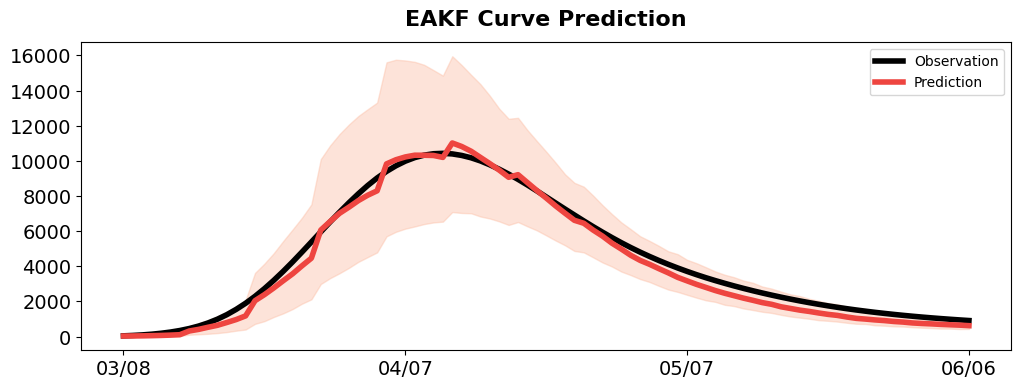

In [ ]:
sim_uhf_week_obs=np.zeros((13,sam_num,42))
sim_NYC_daily_obs=np.zeros((13,sam_num,7))
M_mean=np.zeros((13,42,42*cluster_num))
obs_mean=np.zeros((13,42))
delay_set=np.zeros((14,sam_num,M_t,42))
for w in range(13):
    M_mean[w]=np.mean(M_norm[4+7*w:4+7*(w+1)],axis=0)#Matrix M starts to be counted from February 26. When t = 4, it is March 1.
    obs_mean[w]=np.mean(sim_daily_rate[4+7*w:4+7*(w+1)],axis=0)
std=50
for i in range(13):#Use this week's average mobility data to predict next week's infections.
    sim_uhf_week_obs[i],sim_NYC_daily_obs[i],delay_set[i+1]=week_simulation(post_para[i],10+7*i,11+7*(i+1),post_state[i],sam_num,M_mean[i],i+1,delay_set[i],std,obs_mean[i])
    
sim_NYC=np.zeros((91,sam_num))
for i in range(13):
    for j in range(7):
        for k in range(sam_num):
            sim_NYC[i*7+j][k]=sim_NYC_daily_obs[i][k][j]
NYC_mean=np.median(sim_NYC,axis=1)

##Draw the fitting interval and the mean curve.
hex_colors=['#000000','#EE4540','#fcbba1']
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(date[8:8+13*7], NYC_real_case[8:8+13*7],color=hex_colors[0], linewidth=4)
ax.plot(date[8:8+13*7], NYC_mean,color=hex_colors[1], linewidth=4)

lower=np.array([np.percentile(sim_NYC[i], 2.5) for i in range(len(NYC_mean))])
upper=np.array([np.percentile(sim_NYC[i], 97.5) for i in range(len(NYC_mean))])
plt.fill_between(date[8:8+13*7],lower, upper, interpolate=True, color=hex_colors[2], alpha=0.4)

#Coordinate setting.
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.setp(plt.gca().get_xticklabels(),rotation=0)

plt.legend(labels=['Observation','Prediction'] )

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('EAKF Curve Prediction',loc='center', fontweight='bold', pad=12, fontsize=16)
plt.show()

### UHF-level fitting

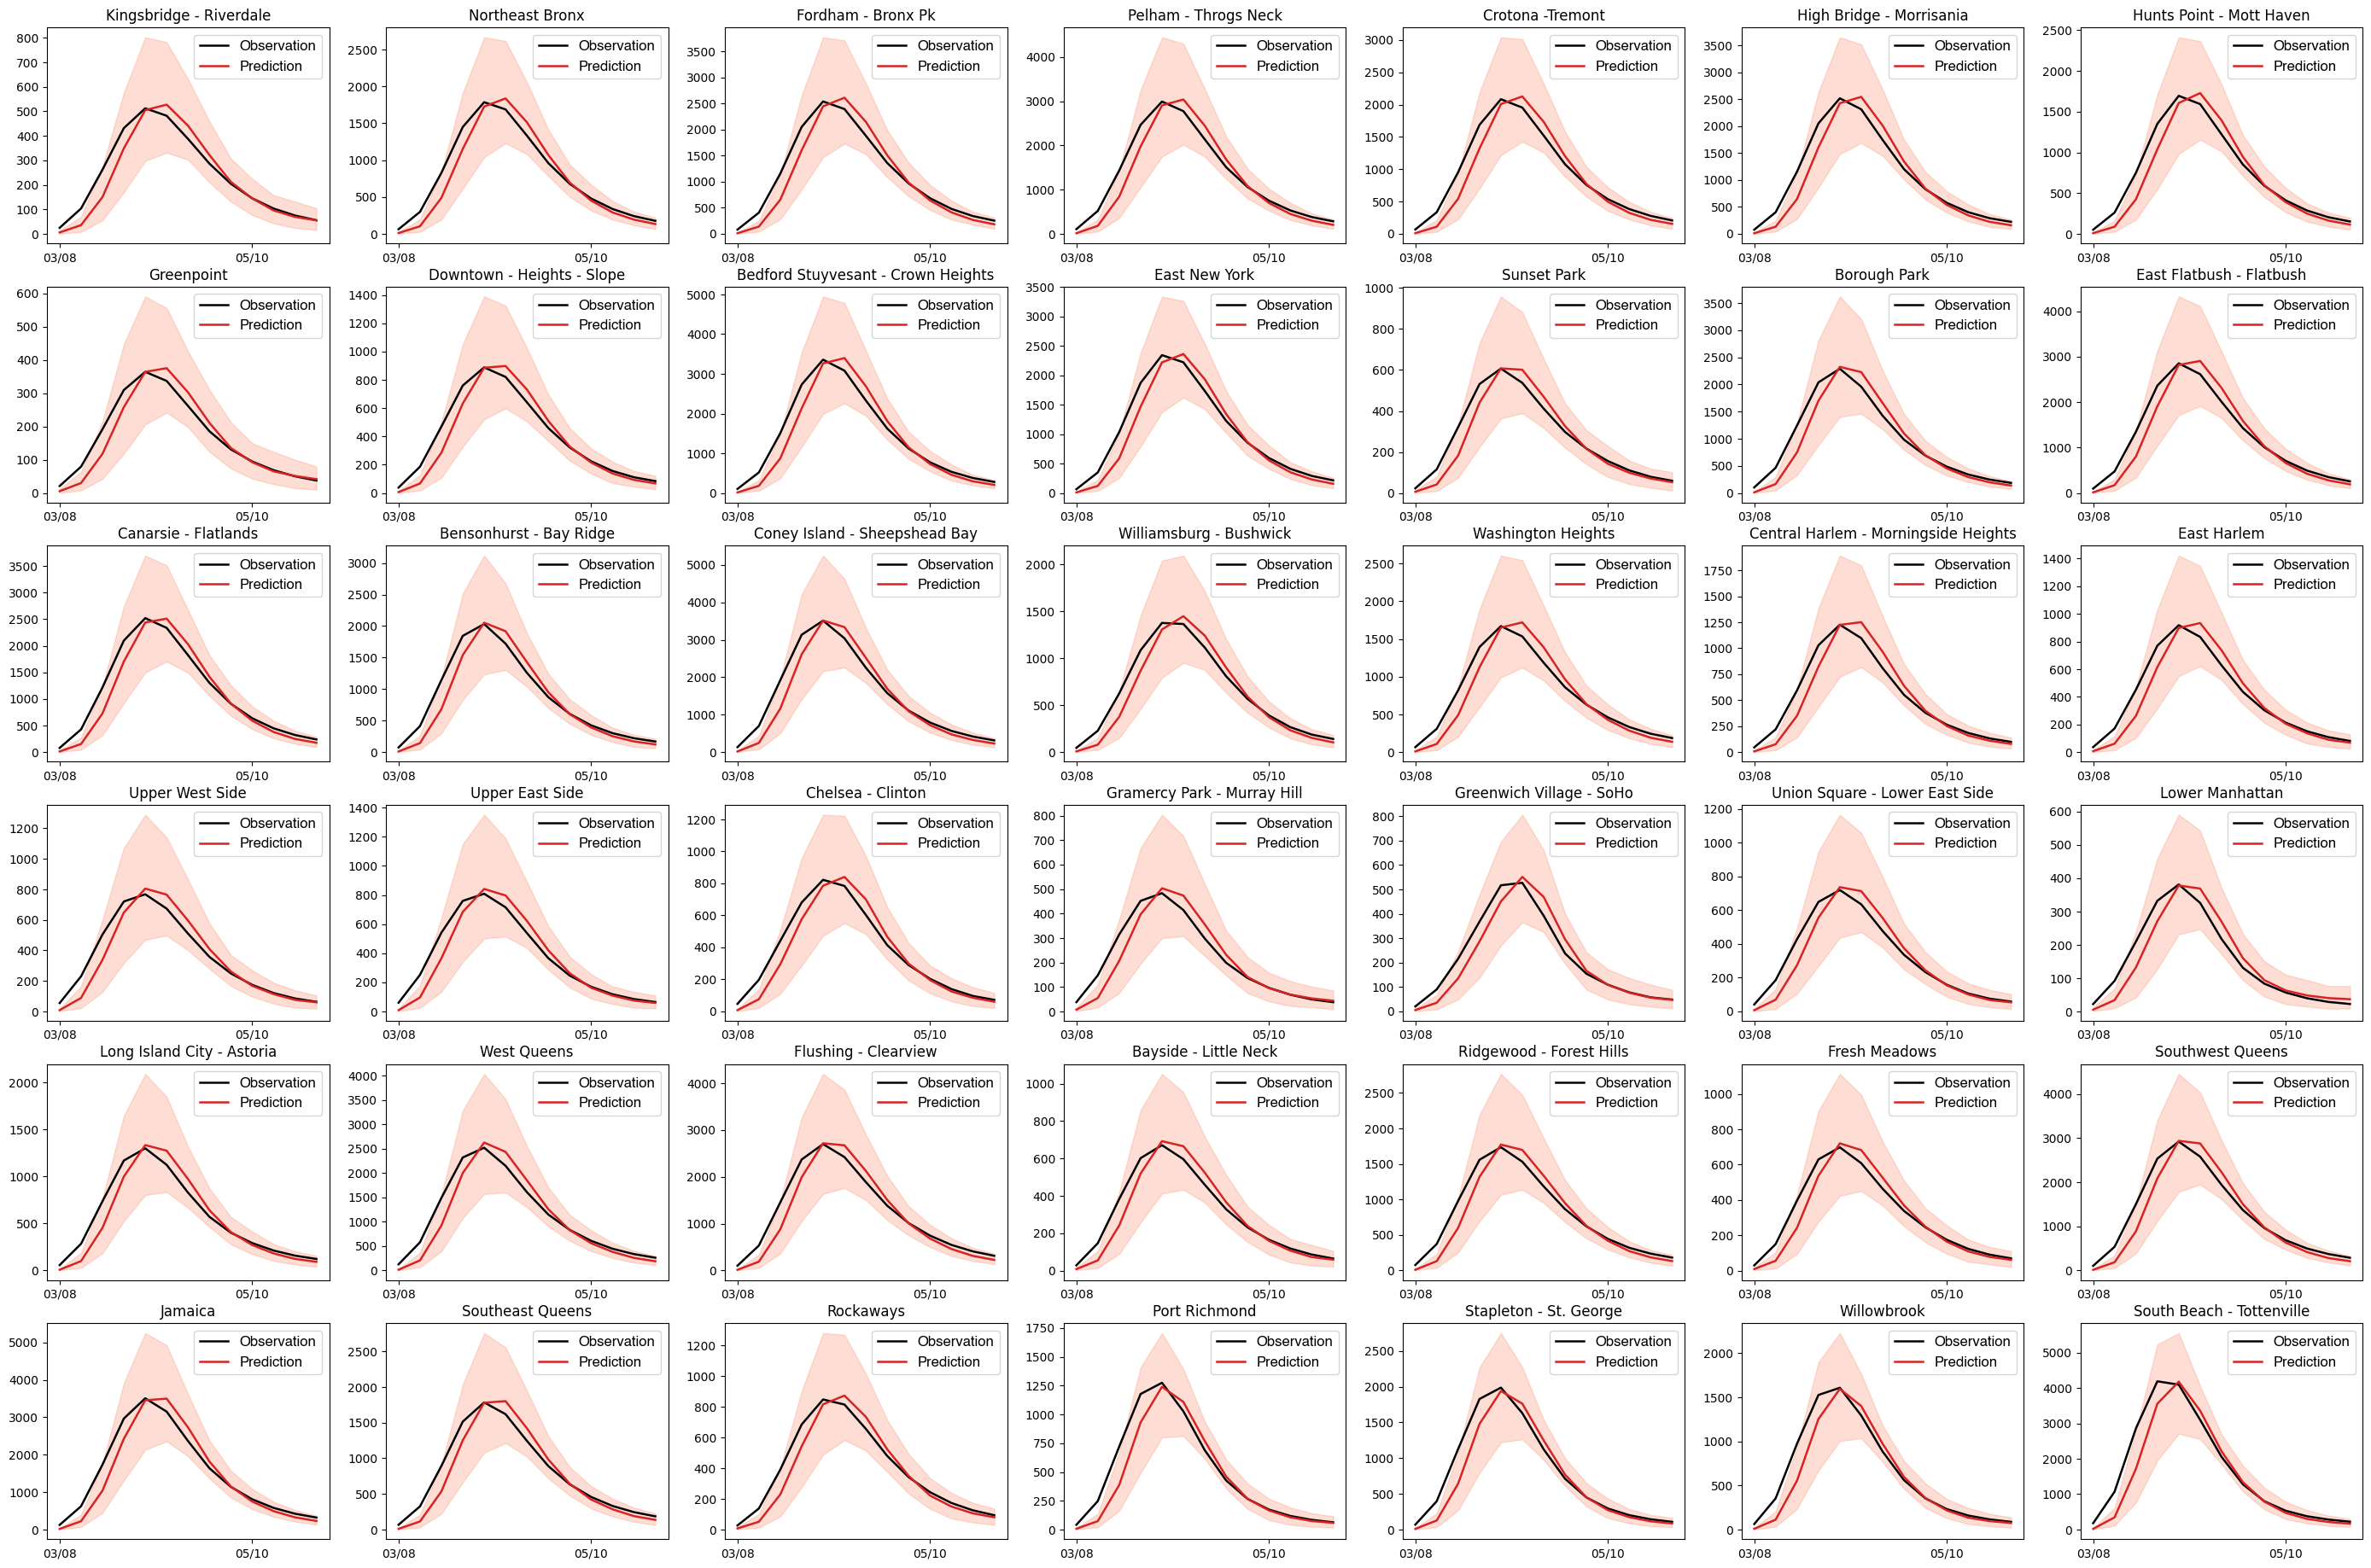

In [ ]:
#Read in the date list
list_path = data_path+"week_set.txt"
week_list=[]
with open(list_path, 'r') as file_l:
    for line in file_l:
       week_list.append(str(line.strip()))
del week_list[0:1]#3.1 is used for training parameters. Prediction starts from 3.8.
week_list[0]
hex_colors1=['#000000','#D72323','#fc9272']
text_font2 = {'family': 'Helvetica', 'size': 12}
uhf_name=pd.read_excel(data_path+'uhfOrder.xlsx',usecols=['UHF_name'],dtype='str')

def week_uhf_plot(w_end,uhfcase_sam):
    fig_i=plt.figure(figsize=(35,23))
    uhfcase=np.median(uhfcase_sam,axis=1)
    for i in range(42):
        ax=plt.subplot(6,7,i+1)
        ax.plot(week_list[:13],uhf_real_case[1:w_end,i],color=hex_colors1[0], linewidth=1.8)#06/07那周用于训练参数 从06/14开始预测 week0=0301 week15=06/14
        ax.plot(week_list[:13],uhfcase[:,i],color=hex_colors1[1], linewidth=1.8)
        lower=np.array([np.percentile(uhfcase_sam[j,:,i], 2.5) for j in range(len(uhfcase))])
        upper=np.array([np.percentile(uhfcase_sam[j,:,i], 97.5) for j in range(len(uhfcase))])
        plt.fill_between(week_list[:13],lower, upper, interpolate=True, color=hex_colors1[2], alpha=0.3)
        plt.title(uhf_name['UHF_name'][i])
        ax.legend(labels=['Observation','Prediction'],prop=text_font2)
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(9))

    plt.show()
 
week_uhf_plot(14,sim_uhf_week_obs)
